## Data preprocessing:
'getData' function return the properties of the simulations as x, and corresponding stellar system labels as y.
* $y = (212, 1)$ (now just a single multiplicity label for each sink particle, NOT always multiplicity in final snapshot)
* $x = (212,$ `num_samples` $\times 14)$ (gas properties sampled at `num_samples` points in simulation prior to sink particle formation)

Gas properties then go through preprocessing step: Yeo-Johnson transformation is used to remove skewness and normalized the data $(\mu = 0, \sigma = 1)$.

## Simple K-mean clustering

Simple kmeans is applied to the transformed data.
* PCA is used to reduced the dimension of data to visualize the result

## Spectral Clustering and Dimension reducing using t-SNE
* The Spectral Clustering with radial bias function kernel is applied to the dataset.
* Use t-SNE as dimension reduction method instead of PCA to see nonlinear relation of the dataset

In [11]:
import numpy as np
import sys
import os
import h5py
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.manifold import TSNE

datadir = '/home/naf999/jupyter-workspace/cse382m/final_project/data/'
figdir  = '/home/naf999/jupyter-workspace/cse382m/final_project/figures_data/'

fname_data = os.path.join(datadir, 'gas_data.hdf5')   

# UPDATED DATA TO BE USED:
# datasets in fname_data: 
#  - data_1point (sample all 14 gas properties at t_formation) (212x14)
#  - data_5point (sample gas properties at 5 times between start of simulation and t_formation) (212x5*14)
#  - data_10point (sample at 10 different times) (212x10*14)
#  - data_20_point (212x20*14)
#  - data_30_point
#  - data_50_point
#  - sink_IDs (212x1)
#  - labels (multiplicity labels) (212x1)

# Return the labels, gas properties (sampled at 1 up to 50 times in simulation), and sink_IDs.
def loadData(fname_data):
    with h5py.File(fname_data, 'r') as f:
        sink_IDs     = f['sink_IDs'][()]      # (212,)
        labels       = f['labels'][()]        # (212,)
        data_1point  = f['data_1point'][()]   # (212, 1x14)
        data_5point  = f['data_5point'][()]   # (212, 5x14)
        data_10point = f['data_10point'][()]  # (212, 10x14)
        data_20point = f['data_20point'][()]  # (212, 20x14)
        data_30point = f['data_30point'][()]  # (212, 30x14)
        data_50point = f['data_50point'][()]  # (212, 50x14)
        
        data = [data_1point, data_5point, data_10point, data_20point, data_30point, data_50point]
        
        # Replace NaN with 0
        for dset in data:
            dset[np.isnan(dset)] = 0.0
            
        # Replace inf with 0 for now.
        for dset in data:
            dset[np.isinf(dset)] = 0.0
            
        n_sinks = len(sink_IDs)
        
    return np.reshape(labels, (n_sinks, 1)), data, np.reshape(sink_IDs, (n_sinks, 1))

def getData(fname_data, num_samples='20'):
    '''
    num_samples = '1', '5', '10', '20', '30', '50'
    '''
    labels, data, sink_IDs = loadData(fname_data)
    y = labels
    if num_samples == '1':
        x = data[0]
    elif num_samples =='5':
        x = data[1]
    elif num_samples == '10':
        x = data[2]
    elif num_samples == '20':
        x = data[3]
    elif num_samples == '30':
        x = data[4]
    else:
        x = data[5]
    return x, y

def runKMeans(x, y, make_fig=True):
    # Pre-process data.
    pt      = PowerTransformer(method= 'yeo-johnson', standardize= True)
    x_trans = pt.fit_transform(x)
    # Run kmeans.
    kmeans = KMeans(n_clusters=4, init='k-means++', algorithm='lloyd')
    kmeans.fit(x_trans)
    # Use PCA to reduce the dimensions to first 2 singular vectors.
    pca = PCA(n_components=2)
    pca.fit(x_trans)
    reducedX = pca.transform(x_trans)
    reducedCluster_center = pca.transform(kmeans.cluster_centers_)
    # Plot the data in the reduced dimensions.
    if make_fig:
        fig, ax = plt.subplots(1, 2, layout = 'tight', figsize=[10, 5])
        color = ['g', 'b', 'k', 'y']
        label = ['1', '2', '3', '4']
        for i in range(0, reducedX.shape[0]):
            ax[0].scatter(reducedX[i, 0], reducedX[i, 1], c = color[np.int32(y[i, 0])-1])
            ax[1].scatter(reducedX[i, 0], reducedX[i, 1], c = color[kmeans.labels_[i]])
            ax[1].scatter(reducedCluster_center[:, 0], reducedCluster_center[:, 1], c='r', marker = 'X', s=150)
            ax[0].set_title('Reduced data with label')
            ax[1].set_title('Clustering result')
        plt.show()
    return kmeans.labels_, kmeans.cluster_centers_, kmeans.inertia_

In [35]:
x, y = getData(fname_data, num_samples='20')

In [36]:
print(np.shape(x))
print(np.shape(y))

(212, 280)
(212, 1)


In [37]:
pt      = PowerTransformer(method= 'yeo-johnson', standardize= True)
x_trans = pt.fit_transform(x)

1.1145822746209133
3.3301483975073825
-1.131170628863367e-16
1.0000000000000004


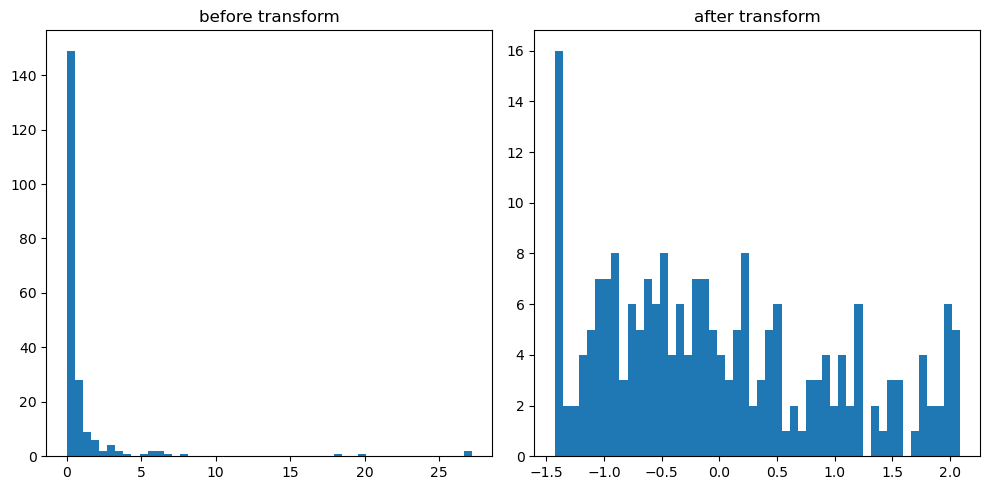

In [26]:
fig1,ax1 = plt.subplots(1, 2, layout = 'tight', figsize = [10, 5])
p = 0
ax1[0].hist(x[:, p], bins = 50)
ax1[0].set_title('before transform')
ax1[1].hist(x_trans[:, p], bins = 50)
ax1[1].set_title('after transform')
print(np.mean(x[:, p]))
print(np.std(x[:, p]))
print(np.mean(x_trans[:, p]))
print(np.std(x_trans[:, p]))

Number of snapshots used = 1


/home/naf999/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


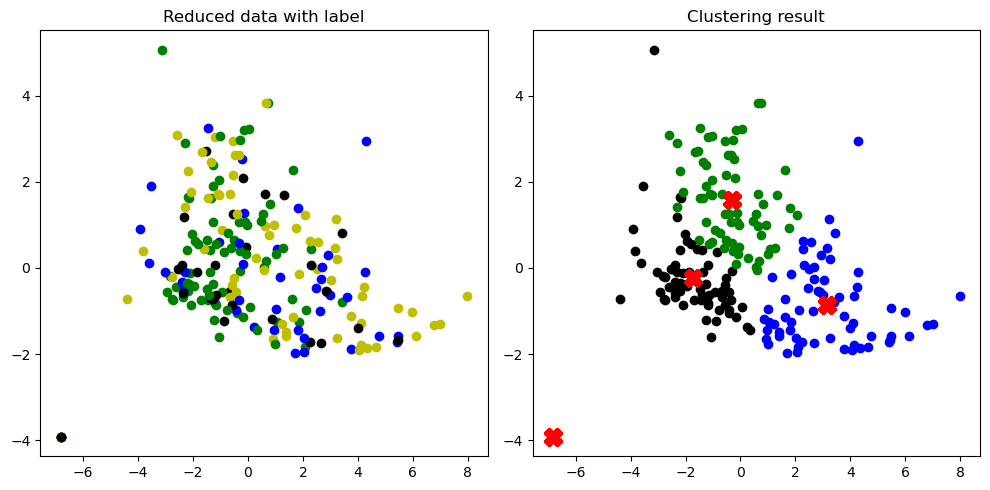

Number of snapshots used = 5


/home/naf999/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


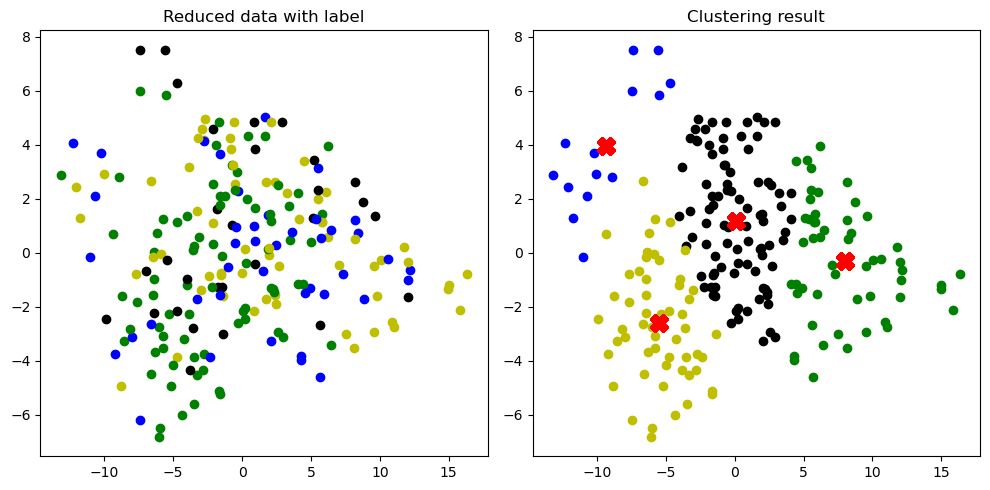

Number of snapshots used = 10


/home/naf999/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


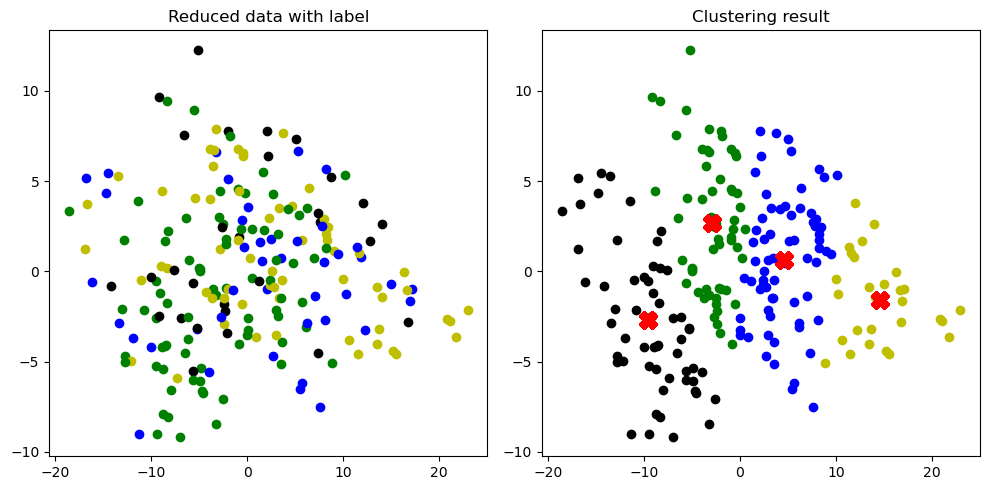

Number of snapshots used = 20


/home/naf999/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


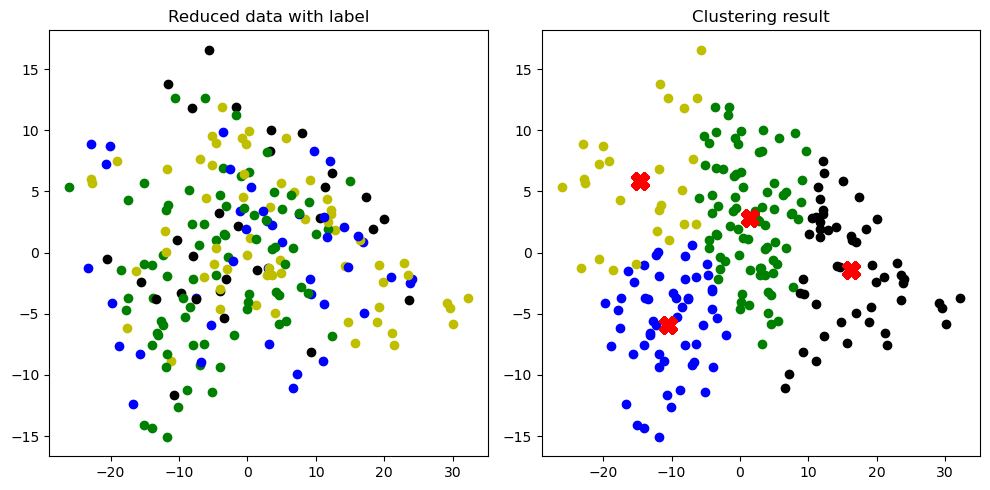

Number of snapshots used = 30


/home/naf999/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


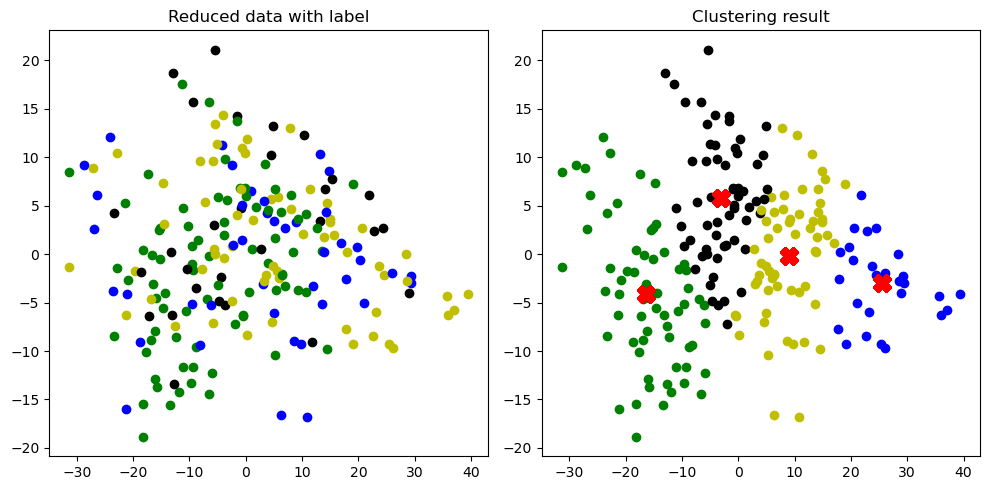

Number of snapshots used = 50


/home/naf999/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


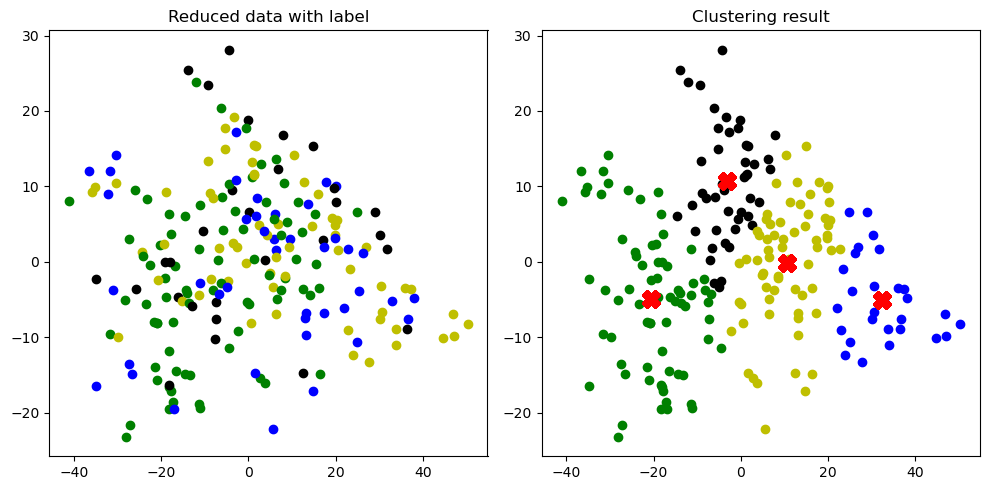

In [34]:
for num_samples in ['1', '5', '10', '20', '30', '50']:
    print('Number of snapshots used = {0:s}'.format(num_samples))
    x, y = getData(fname_data, num_samples=num_samples)
    labels, centers, inertia = runKMeans(x, y, make_fig=True)

/home/naf999/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Text(0.5, 1.0, 'Clustering result')

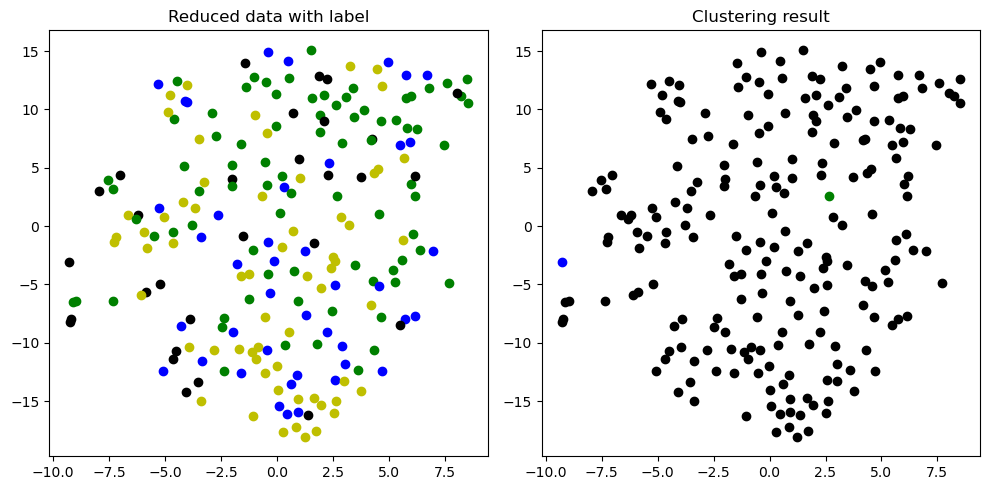

In [38]:
spCluster = SpectralClustering(n_clusters = 4, affinity='rbf')
spCluster.fit(x_trans)
tSNE = TSNE(n_components=2, random_state=100)
reducedX_tsne= tSNE.fit_transform(x_trans)
fig3,ax3 = plt.subplots(1,2, layout = 'tight', figsize=[10, 5])

color = ['g', 'b', 'k', 'y']
label = ['1', '2', '3', '4']
# plot the data in the reduced dim
for i in range(0, reducedX.shape[0]):
    ax3[0].scatter(reducedX_tsne[i, 0], reducedX_tsne[i, 1], c = color[np.int32(y[i, 0])-1])
    ax3[1].scatter(reducedX_tsne[i, 0], reducedX_tsne[i, 1], c = color[spCluster.labels_[i]])

#ax3[1].scatter(reducedCluster_center[:, 0], reducedCluster_center[:, 1], c='r', marker = 'X', s=150)
ax3[0].set_title('Reduced data with label')
ax3[1].set_title('Clustering result')